## Fake News or Not?
#### Ford St. John and Matthew Duc Nguyen
<img src="https://static01.nyt.com/images/2019/10/02/business/02TRUMPMEDIA-01/02TRUMPMEDIA-01-superJumbo.jpg" height=500 width=750>

Using the Kaggle dataset [Fake News](https://www.kaggle.com/c/fake-news/data) we will attempt to train a machine learning model that can identify news articles as "reliable" or "unreliable" (e.g. fake) based on the following article attributes
1. id: a unique ID to identify the article
2. title: the title of the news article
3. author: the author of the news article
4. text: the content (actual text) of the news article; may or may not be incomplete

Articles are labeled with a boolean 1|0 indicator with 1 = "unreliable" and 0 = "reliable"

## Step 1: Exploratory data analysis
Before undertaking any model training, we want to get a feel for the data and identify features that we think might merit further exploration.  Our dataset has been pre-split for us into a training and testing set.  We'll use the training dataset to train our model, and use the testing dataset to test our model on data it's never seen before

In [136]:
# Check if the kaggle.json file is in our local directory. If not we need to retrive it from Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import shutil
import stat

if not os.path.exists(os.path.join(os.getcwd(), 'kaggle.json')):  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for f in file_list:
    if f['title'] == 'kaggle.json':
      f.GetContentFile('kaggle.json')  

# Move kaggle.json to the .kaggle directory in /root
if not os.path.exists('/root/.kaggle/kaggle.json'):
  filepath = os.path.join(os.getcwd(), 'kaggle.json')
  if not os.path.isdir('/root/.kaggle/'):
    os.makedirs('/root/.kaggle/')
  shutil.move(filepath, '/root/.kaggle/')
  os.chmod('/root/.kaggle/kaggle.json', stat.S_IRWXU)

In [137]:
# Imports needed to acquire and hold our data
import pandas as pd
import kaggle

# Import the data using the kaggle API
!kaggle competitions download -c fake-news

# Unzip the data and read it in as a Pandas DataFrame
from zipfile import ZipFile
if 'test.csv.zip' in os.listdir('.') and 'train.csv.zip' in os.listdir('.'):
  with ZipFile('test.csv.zip', 'r') as zipobj:
    zipobj.extractall()
  with ZipFile('train.csv.zip') as zipobj:
    zipobj.extractall()
else:
  with ZipFile('fake-news.zip', 'r') as zipobj:
    zipobj.extractall()
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('submit.csv')

# Join the test and submit datasets together.  Submit contains the "true" classification for the articles present in the test dataset
test = pd.merge(test, submit)

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
submit.csv: Skipping, found more recently modified local copy (use --force to force download)


With our data loaded, we can now begin to explore our data.  We'll start by simply looking at the head of both datasets.  We'll then look at the relative number of "fake" news articles to reliable news articles and compare those rates in our training and testing datasets

In [138]:
# Let's look at the first few records of our data 
print("******** Training dataset *************")
print(train.head(5))
print("****************************************")
print()
print("********* Testing dataset **************")
print(test.head(5))
print("*****************************************")

******** Training dataset *************
   id  ... label
0   0  ...     1
1   1  ...     0
2   2  ...     1
3   3  ...     1
4   4  ...     1

[5 rows x 5 columns]
****************************************

********* Testing dataset **************
      id  ... label
0  20800  ...     0
1  20801  ...     1
2  20802  ...     0
3  20803  ...     1
4  20804  ...     1

[5 rows x 5 columns]
*****************************************


Text(0, 0.5, 'Count')

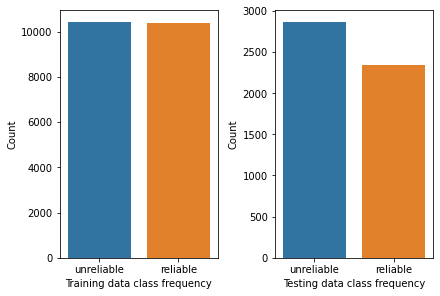

In [139]:
# Let's look at the relative rates of fake news to reliable news
# Import visualization packages
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Prepare training set data
train_counts = train['label'].value_counts()
train_counts.rename({0: 'reliable', 1: 'unreliable'}, inplace=True)
# Prepare testing set data
test_counts = test['label'].value_counts()
test_counts.rename({0: 'reliable', 1: 'unreliable'}, inplace=True)

# Plot it
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
#fig.tight_layout()
sns.barplot(x=train_counts.index, y=train_counts, ax=ax1)
ax1.set_xlabel('Training data class frequency')
ax1.set_ylabel('Count')
sns.barplot(x=test_counts.index, y=test_counts, ax=ax2)
ax2.set_xlabel('Testing data class frequency')
ax2.set_ylabel('Count')

So it looks like it's a 50:50 split between "fake" articles and reliable articles in our training dataset, and > 50% of the articles in our test dataset are labeled as fake (unreliable).  The distributions are relatively similar between the two datasets, so we won't worry too much that there's a variance.  Next, let's check and see if any of our records contain missing values.

In [140]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

There are 558 records missing a title, 1957 records missing the author and 39 records missing any article content at all.  We likely want to drop records that don't contain any article content.  How can an article be fake news or not if it doesn't contain any content?  Let's quickly look at the data records that are listed as missing "text"

In [141]:
missing_text = train[train.text.isna()]
missing_text

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1
2169,2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NaN,NaN,1
2793,2793,«Pourquoi je suis candidat à la présidentielle...,NaN,NaN,1
3329,3329,GuinessBook : 100 millions d’Américains batten...,NaN,NaN,1
3729,3729,Les Américains ne sont plus qu’à quelques heur...,NaN,NaN,1
4288,4288,Hillary Clinton en 5 dates >> Le Gorafi,NaN,NaN,1


Makes sense - an article that doesn't have any text is "unreliable".  But this isn't really interesting for prediction purposes, so let's remove these records that have missing article content from our training and testing sets

In [142]:
train = train[train.text.notna()]
test = test[test.text.notna()]

Articles that are missing the author or title are probably pretty suspect, let's see if we can confirm that with a confusion matrix

In [143]:
pd.crosstab(train.author.isna(), train.label, rownames=['Missing Author'], normalize='index')

label,0,1
Missing Author,,
False,0.549859,0.450141
True,0.013556,0.986444


In [144]:
pd.crosstab(train.title.isna(), train.label, rownames=['Missing Title'], normalize='index')

label,0,1
Missing Title,,
False,0.514132,0.485868
True,0.000000,1.000000


Although not surprising, we probably want to throw these records out too.  Every article that's missing a title was labeled as "unreliable" in our training dataset.  Not very interesting for classification, so we likely want to remove these from the problem space.  Similarly, 98.6% of the articles that are missing an author are also labeled as unreliable. For posterity, let's review the articles that are missing an author, but **are not** labeled as unreliable, to try and see if we can glean any insight into why these were labeled the way they were

In [145]:
missing_author_not_fake = train[(train.author.isna()) & (train.label == 0)]
missing_author_not_fake

,id,title,author,text,label
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
685,685,The New York Times to Offer Open Access on Web...,NaN,The New York Times is inviting readers to take...,0
2785,2785,How the Poll Was Conducted - The New York Times,NaN,The latest New York News Poll is based on te...,0
3203,3203,37 Who Saw Murder Didn’t Call the Police - The...,NaN,"For more than half an hour 38 respectable, law...",0
3470,3470,"‘My First Gay Bar’: Rachel Maddow, Andy Cohen ...",NaN,"For generations of gays and lesbians, especial...",0
3675,3675,"2 TV Shows, 4 Books and 7 Viral Videos for You...",NaN,Summer’s almost over. Here’s a cultural diet f...,0
5239,5239,Text of F.B.I. Director’s Remarks on Investiga...,NaN,Following is the prepared text of remarks by D...,0
5608,5608,"As Hurricane Matthew Nears U.S., Residents Get...",NaN,"• Hurricane Matthew, a deadly storm with maxim...",0
5911,5911,Keep Your Family Close and Your Roomba Closer ...,NaN,How lovable can a robot be? A study of Roomba ...,0
7032,7032,Reactions to the Supreme Court Ruling on Texas...,NaN,"In a major abortion ruling Monday, the Supreme...",0


Let's inspect one of these records in detail to see if we can glean why the article is suspicious or not

In [146]:
train.iloc[8].title
train.iloc[8].text

'Donald J. Trump is scheduled to make a highly anticipated visit to an   church in Detroit on Saturday, the first such visit of his campaign. There, he will participate in a    session conducted by Bishop Wayne T. Jackson of the church, Great Faith Ministries International. Given the importance of the visit, the Trump team went so far as to script Mr. Trump’s answers to Bishop Jackson’s questions, which were submitted in advance. After this article was published on Thursday night, a campaign official said that Mr. Trump would also speak to the church’s congregation and then tour some neighborhoods with Ben Carson, a former presidential candidate and Detroit native. Below are excerpts from a draft of the script that was obtained by The New York Times. _____ Mr. Trump there is racial divide in our country and it is evident that the tension is boiling over. Case and point Reverend Pinckney in South Carolina was gunned down when a white young man came into their Bible Study and slaughtered

The title informs that this article came from the New York Times, a very reputable news source.  Even though the author is missing, perhaps the fact that this is a New York Times article negates any reliability issues we might infer from the missing author.  For now we'll leave in records that are missing their authors, although our ML models will likely always classify articles missing an author as unreliable (as the misclassification error will be very minimal if we classify the few articles **without** authors as unreliable, even though they were labeled as reliable).  We'll throw out the records that are missing a title, as all of those were considered unreliable

In [147]:
train = train[train.title.notna()]
test = test[test.title.notna()]

Before completing our EDA, let's review some really basic statistics about titles, authors, and text as they relate to reliable or unreliable news sources.  For authors and titles, let's see if the length of the title or the number of authors is at all related to the reliability of the article.  For the text content, let's see if the number of words has any impact

In [148]:
# Import the nltk (Natural Language Toolkit) library to perform word and sentence processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [149]:
# Cast the title, author and text to str types
train[['title','author','text']] = train[['title','author','text']].astype('string')
test[['title','author','text']] = test[['title','author','text']].astype('string')

# Compute the length of the title
train['title-length'] = train['title'].apply(lambda x: len(str(x)))
test['title-length'] = test['title'].apply(lambda x: len(str(x)))

# Get the number of words in the title and the main article text.  Note it takes a while for the tokenization
stoplist = set(stopwords.words('english') + list(string.punctuation)) # Sets have O(1) lookup in Python
def count_words(s):
    return len([word for word in word_tokenize(s) if word.lower() not in stoplist and not word.isdigit()])

train['title-word-count'] = train['title'].apply(count_words)
test['title-word-count'] = test['title'].apply(count_words)
# Note that nltk.word_tokenize is relatively slow on large text entries.  We'll use a simpler function for the number of words in the article "text" field (though not as accurate)
train['text-word-count'] = train['text'].apply(lambda x: len(str(x).split()))
test['text-word-count'] = test['text'].apply(lambda x: len(str(x).split()))


"""
Get the number of authors from the author field by searching for proper nouns
The function we use is an amended version of this code here: https://tim.mcnamara.nz/post/2650550090/extracting-names-with-6-lines-of-python-code
"""
def get_people(text):
    people = []
    for sentence in sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sentence))):
            if hasattr(chunk, 'label'):
                if chunk.label() == 'PERSON':
                    people.append(' '.join(c[0] for c in chunk.leaves()))
    return people
train['author-count'] = train['author'].apply(lambda x: len(get_people(x)) if pd.notnull(x) else 0)
test['author-count'] = test['author'].apply(lambda x: len(get_people(x)) if pd.notnull(x) else 0)

Text(0.5, 1.0, '# Authors in reliable news articles')

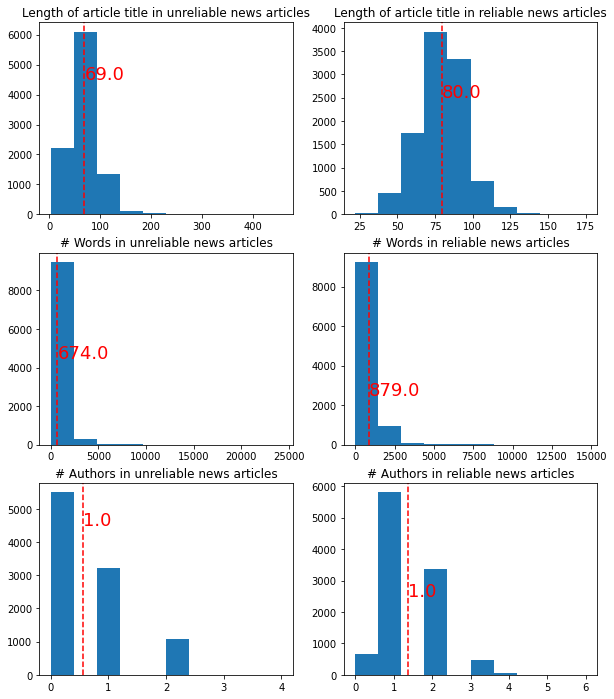

In [150]:
# We'll create plots of these values showing the frequency of unreliable articles as it relates to the counts
fix, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=2, figsize=(10,12))
# Length of the article title
train_title_length = train[train.label == 1]['title-length']
ax1[0].hist(train_title_length)
ax1[0].axvline(train_title_length.mean(), linestyle='dashed', color='red')
ax1[0].text(train_title_length.mean(), 4500, str(round(train_title_length.mean(), 0)), color='red', fontsize=18)
ax1[0].set_title('Length of article title in unreliable news articles')
train_title_length = train[train.label == 0]['title-length']
ax1[1].hist(train_title_length)
ax1[1].axvline(train_title_length.mean(), linestyle='dashed', color='red')
ax1[1].text(train_title_length.mean(), 2500, str(round(train_title_length.mean(), 0)), color='red', fontsize=18)
ax1[1].set_title('Length of article title in reliable news articles')

# Number of words in the article
train_text_words = train[train.label == 1]['text-word-count']
ax2[0].hist(train_text_words)
ax2[0].axvline(train_text_words.mean(), linestyle='dashed', color='red')
ax2[0].text(train_text_words.mean(), 4500, str(round(train_text_words.mean(), 0)), color='red', fontsize=18)
ax2[0].set_title('# Words in unreliable news articles')
train_text_words = train[train.label == 0]['text-word-count']
ax2[1].hist(train_text_words)
ax2[1].axvline(train_text_words.mean(), linestyle='dashed', color='red')
ax2[1].text(train_text_words.mean(), 2500, str(round(train_text_words.mean(), 0)), color='red', fontsize=18)
ax2[1].set_title('# Words in reliable news articles')

# Number of authors
train_authors = train[train.label == 1]['author-count']
ax3[0].hist(train_authors)
ax3[0].axvline(train_authors.mean(), linestyle='dashed', color='red')
ax3[0].text(train_authors.mean(), 4500, str(round(train_authors.mean(), 0)), color='red', fontsize=18)
ax3[0].set_title('# Authors in unreliable news articles')
train_authors = train[train.label == 0]['author-count']
ax3[1].hist(train_authors)
ax3[1].axvline(train_authors.mean(), linestyle='dashed', color='red')
ax3[1].text(train_authors.mean(), 2500, str(round(train_authors.mean(), 0)), color='red', fontsize=18)
ax3[1].set_title('# Authors in reliable news articles')

## Step 2: Text Processing
In order to use our text fields for model building, we need to process the text data within each field to transform it into a format suitable for modeling.  This generally involves the following steps:

1. Simple cleansing
    1. Remove punctuation, special characters, URLs, etc.
    2. Remove leading, trailing and extra white space/tabs
    3. Correct typos, slang, and convert abbreviated words into their "normal" form
2. Stop word removal - remove generic stop words from the text fiel such as "I", "you", "a", "the", etc.  These don't add much meaning to the actual content of the text
3. Word vectorization - machine learning models typically need numerical data.  Word vectorization is the process of converting raw text into a vector of numerical data
    1. We can use sklearn BoW (Bag of Words) and compute the following:
        1. Count vector - builds a list of all words from a corpus of documents (e.g. list of documents) and counts how many the words appear in each document
        2. TF-IDF (Term Frequency Inverse Document Frequencies) - The "value" of words increases proportionally to the count of that word in the document, but is inversely propotional to the frequency of the word in the corpus
    2. Word2Vec - another NLP library, uses a neural net to learn word associations from a corpus of text. The neural net can detect synonomous words or suggest additional words for partial sentences.  This library builds word vectors much like BoW does 

In [151]:
"""
Below are the methods we'll use to first cleanse the text data in our title and text (e.g. article) fields.
The "author" field we'll perform more custom processing
"""
import re

# Below we're going to try and use Pandas vectorized methods to make processing as quick as possible
cachedstopwords = stopwords.words('english')
def simple_cleanse(df, column_name):
    # Convert to lowercase
    df[column_name+'_clean'] = df[column_name].str.lower()
    # Strip leading and trailing whitespace
    df[column_name+'_clean'] = df[column_name+'_clean'].str.strip()
    #Remove all punctuation
    df[column_name+'_clean'] = df[column_name+'_clean'].str.translate(str.maketrans('','',string.punctuation))
    # Remove stopwords
    df[column_name+'_clean'] = df[column_name+'_clean'].apply(lambda text: ' '.join([word for word in text.split() if word not in cachedstopwords]))
    # Remove numbers
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'[0-9]+','', regex=True)
    # Remove URLs (anything that begins with HTTP)
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'http\S+','', regex=True)
    # Remove redundant whitespace
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'\s+', ' ', regex=True)
    # Remove apostrophes - these aren't really relevant for word analysis
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'(\'|\"|\`|\’)', "", regex=True)
        
simple_cleanse(train, 'text')
simple_cleanse(train, 'title')
simple_cleanse(test, 'text')
simple_cleanse(test, 'title')

# Let's also tokenize our "cleaned" words for more processing
train['text_clean_tok'] = train['text_clean'].apply(word_tokenize)
train['title_clean_tok'] = train['title_clean'].apply(word_tokenize)
test['text_clean_tok'] = test['text_clean'].apply(word_tokenize)
test['title_clean_tok'] = test['title_clean'].apply(word_tokenize)

In [152]:
pip install pyspellchecker

In [153]:
"""
Additional features
    Here we'll add some other features which might be of interest.  For example, does the article text contain mispelled words?  If so how many?
"""
# Check for mispelled words
from spellchecker import SpellChecker
spell = SpellChecker()
train['title_mispelled'] = train['title_clean_tok'].apply(lambda x: len(spell.unknown(x)))
train['text_mispelled'] = train['text_clean_tok'].apply(lambda x: len(spell.unknown(x)))
test['title_mispelled'] = test['title_clean_tok'].apply(lambda x: len(spell.unknown(x)))
test['text_mispelled'] = test['text_clean_tok'].apply(lambda x: len(spell.unknown(x)))

# Create an authors categorical variable
# 1. 1 person
# 2. 2 people
# 3. 3 people
# 4. 4 people
# 5. An organization (e.g. NewsWeek, CNN, etc.)
# 6. Anonymous
# 7. Unknown (a catch-all category if we can't figure out if there was a legitimate author or not)
num_dict = {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}
def create_author_category(row):
    if row.author_count == 0:
      if pd.isna(row.author):
        return 'unknown'
      if 'Anonymous' in row.author or 'UID' in row.author:
        return 'anonymous'
      str_split = row.author.split()
      if len(str_split) <= 1:
        return 'unknown'
      elif len(str_split) == 3 and 'Dr' in str_split[0]:
        return 'one.person'
      elif len(str_split) >= 2 and len(str_split) <= 3 and 'The' not in row.author and str_split[0][0].isupper() and str_split[1][0].isupper():
        return 'one.person'
      else:
        return 'unknown'
    else:
      if row.author_count in num_dict:
        if row.author_count == 1:
          return 'one.person'
        elif row.author_count < 4:
          return num_dict[row.author_count]+'.people'
        else:
          return 'four.plus.people'
      else:
        return 'unknown'

train = train.rename(columns={'author-count':'author_count'})
test = test.rename(columns={'author-count':'author_count'})
train['author_category'] = train.apply(create_author_category, axis=1).astype('category')
test['author_category'] = test.apply(create_author_category, axis=1).astype('category')


In [158]:
# Final feature preparation
"""
Below we make use of sklearns ColumnTransformer method which enables us to prepare a variety of different features based on the data-type of the feature
"""
features = ['title-length','title-word-count', 'text-word-count', 'text_clean', 'title_clean', 'title_mispelled', 'text_mispelled', 'author_category']
X_train, X_test = train[features], test[features]
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
column_transformer = ColumnTransformer(
    [
     ('category', OneHotEncoder(dtype='int'), ['author_category']),
     ('text_tfidf', TfidfVectorizer(), 'text_clean'),
     ('title_tfidf', TfidfVectorizer(), 'title_clean')
     ],
     remainder="passthrough"
)
X_train_features = column_transformer.fit_transform(X_train)
X_test_features = column_transformer.transform(X_test)

## Step 3: Building ML Algorithms
In this section we'll use our vectorized text data with some of our other features to try and classify articles as real or fake. There are a number of ML models that one can utilize for classification, but we're going to consider a subset of the model space for this exercise
1. Naive Bayes - this is usually a good baseline to compare other algorithms against.  Basically we just apply Bayes' theorem with the naive assumption of conditional independence between every pair of features
2. Logistic Regression - logistic regression models are very interpretable, in that the coefficient value computed on a feature states its' relation to the predicted probability for a class value (in terms of log odds).  For example, a positive coefficient on the "number of mispelled words in the article" features can be interpreted as the more mispelled words found in the article, the more likely the article is to be fake
3. Gradient Boosting - this is the ML algorithm we'll focus on in this project.  Gradient boosting has a lot of coverage in the literature, and is known to provide very powerful predictors.  The drawback is that gradient boosting tends to overfit the data.  In this project we benefit from the presence of a test set that we can provide in addition to our training dataset.  When building the gradient boost model, the algorithm will penalize features that overfit on the train dataset but underfit (or provide poor prediction) on the test dataset

Classification Report on Train Dataset: 
               precision    recall  f1-score   support

           0       0.72      0.84      0.78     10387
           1       0.80      0.66      0.72      9816

    accuracy                           0.75     20203
   macro avg       0.76      0.75      0.75     20203
weighted avg       0.76      0.75      0.75     20203

Training set AUC: 81.0%
Training set Accuracy: 75.3%

Classification Report on Test Dataset: 
               precision    recall  f1-score   support

           0       0.71      0.94      0.81      2334
           1       0.92      0.67      0.78      2737

    accuracy                           0.79      5071
   macro avg       0.82      0.80      0.79      5071
weighted avg       0.83      0.79      0.79      5071

Testing set AUC: 94.0%
Testing set Accuracy: 79.3%


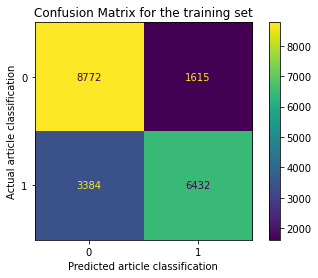

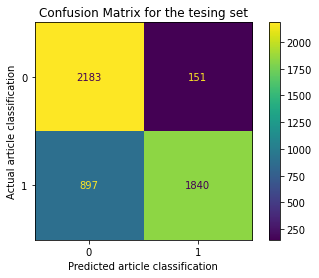

In [160]:
"""
Train a Naive Bayes Multinomial classifier - this is typically used for text classification
This is a good "base" model against which we can compare our results from more "advanced" algorithms
"""
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Train the model 
nb_classifier = MultinomialNB().fit(X_train_features, train.label)

# Confirm it's accuracy on data it's never seen before
nb_train_predict = nb_classifier.predict(X_train_features)
nb_test_predict = nb_classifier.predict(X_test_features)

# Print the model fit statistics
print("Classification Report on Train Dataset: \n", classification_report(train.label, nb_train_predict))
train_cm = confusion_matrix(train.label, nb_train_predict)
train_cm_disp = ConfusionMatrixDisplay(train_cm, display_labels=[0,1])
train_cm_disp.plot()
train_cm_disp.ax_.set(
    title='Confusion Matrix for the training set',
    xlabel='Predicted article classification',
    ylabel='Actual article classification'
)
fpr, tpr, thresholds = roc_curve(train.label, nb_classifier.predict_proba(X_train_features)[:,1])
auc_val = auc(fpr, tpr)
train_accuracy = accuracy_score(train.label, nb_train_predict)
print(f"Training set AUC: {auc_val:.1%}")
print(f"Training set Accuracy: {train_accuracy:.1%}")
print()
print("Classification Report on Test Dataset: \n", classification_report(test.label, nb_test_predict))
test_cm = confusion_matrix(test.label, nb_test_predict)
test_cm_disp = ConfusionMatrixDisplay(test_cm, display_labels=[0,1])
test_cm_disp.plot()
test_cm_disp.ax_.set(
    title='Confusion Matrix for the tesing set',
    xlabel='Predicted article classification',
    ylabel='Actual article classification'
)
fpr, tpr, thresholds = roc_curve(test.label, nb_classifier.predict_proba(X_test_features)[:,1])
auc_val = auc(fpr, tpr)
test_accuracy = accuracy_score(test.label, nb_test_predict)
print(f"Testing set AUC: {auc_val:.1%}")
print(f"Testing set Accuracy: {test_accuracy:.1%}")


**Analysis of the Naive Bayes Model**

Surprisingly, we achieve a better AUC and Accuracy statistic on our testing dataset then we do on the dataset we used to train the model (the training dataset).

The accuracy statistic is simply the number of records the model correctly classifies (e.g. TP + TN) as a percentage of all records in the dataset.  The AUC statistic can be interpreted as the probability that our model ranks a random fake article "higher" (e.g. more likely to be fake) than a random reliable article. 

One possible explanation for this discrepancy could be the number of records in the distribution of fake vs. reliable articles in both datasets.  Our training dataset is approximately 4x the size of our testing dataset, and has approximately a 50-50 split between fake articles and reliabile articles.  Our testing dataset is much smaller by comparison, and has > 50% fake articles relative to reliable articles.  These discrepancies in distribution could be influencing the results



Classification Report on Train Dataset: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     10387
           1       0.98      0.99      0.99      9816

    accuracy                           0.99     20203
   macro avg       0.99      0.99      0.99     20203
weighted avg       0.99      0.99      0.99     20203

Training set AUC: 99.9%
Training set Accuracy: 98.6%

Classification Report on Test Dataset: 
               precision    recall  f1-score   support

           0       0.59      0.65      0.62      2334
           1       0.67      0.61      0.64      2737

    accuracy                           0.63      5071
   macro avg       0.63      0.63      0.63      5071
weighted avg       0.63      0.63      0.63      5071

Testing set AUC: 69.2%
Testing set Accuracy: 62.7%


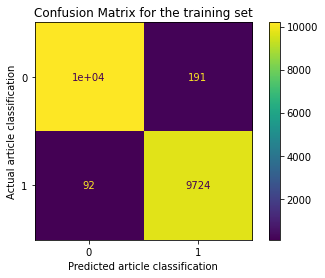

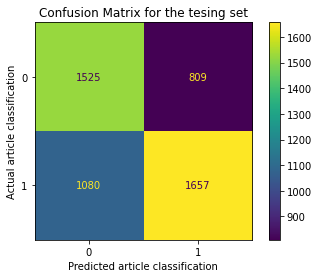

In [163]:
"""
Train a logistic regression model - these models are very interpretable relative to unsupervised methods (like Gradient Boost, which we'll explore next)
"""
from sklearn.linear_model import LogisticRegression

# Train the model
lr_classifier = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train_features, train.label)

# Generate predictions
lr_train_predict = lr_classifier.predict(X_train_features)
lr_test_predict = lr_classifier.predict(X_test_features)

# Print the model fit statistics
print("Classification Report on Train Dataset: \n", classification_report(train.label, lr_train_predict))
train_cm = confusion_matrix(train.label, lr_train_predict)
train_cm_disp = ConfusionMatrixDisplay(train_cm, display_labels=[0,1])
train_cm_disp.plot()
train_cm_disp.ax_.set(
    title='Confusion Matrix for the training set',
    xlabel='Predicted article classification',
    ylabel='Actual article classification'
)
fpr, tpr, thresholds = roc_curve(train.label, lr_classifier.predict_proba(X_train_features)[:,1])
auc_val = auc(fpr, tpr)
train_accuracy = accuracy_score(train.label, lr_train_predict)
print(f"Training set AUC: {auc_val:.1%}")
print(f"Training set Accuracy: {train_accuracy:.1%}")
print()
print("Classification Report on Test Dataset: \n", classification_report(test.label, lr_test_predict))
test_cm = confusion_matrix(test.label, lr_test_predict)
test_cm_disp = ConfusionMatrixDisplay(test_cm, display_labels=[0,1])
test_cm_disp.plot()
test_cm_disp.ax_.set(
    title='Confusion Matrix for the tesing set',
    xlabel='Predicted article classification',
    ylabel='Actual article classification'
)
fpr, tpr, thresholds = roc_curve(test.label, lr_classifier.predict_proba(X_test_features)[:,1])
auc_val = auc(fpr, tpr)
test_accuracy = accuracy_score(test.label, lr_test_predict)
print(f"Testing set AUC: {auc_val:.1%}")
print(f"Testing set Accuracy: {test_accuracy:.1%}")



**Analysis of Logistic Regression Model**
Unlike our Naive Bayes classifier, our logistic regression model vastly overfits on our training data (AUC ~ 100%) and generally underperforms on our testing dataset (AUC ~ 70%).  This is unsurprising, as model coefficients are optimized for the dataset the model is trained on, which can lead to overfitting (and poorer generalization on data the model hasn't seen yet).

Gradient Boosting attempts to address this issue by simultaneously training the model on **both** the train and testing dataset to try and balance the model parameters.

In our final section below we will explore fitting a Gradient Boost model to try and generalize more effectively on the test dataset